In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib
from sklearn.preprocessing import LabelEncoder

In [0]:
df = pd.read_csv("bmtrain.csv")

In [0]:
df['Item_Fat_Content'].replace(['Low Fat','LF','low fat'],1,inplace=True)
df['Item_Fat_Content'].replace(['Regular','reg'],2,inplace=True)

from datetime import date
current_year = date.today().year

df['Outlet_Establishment_Year'] = current_year - df['Outlet_Establishment_Year'] 
df['Outlet_Size'].replace({'Small':1,'Medium':2,'High':3},inplace=True)
df['Outlet_Location_Type'].replace({'Tier 1':1,'Tier 2':2,'Tier 3':3},inplace=True)
df['Outlet_Type'].replace({'Grocery Store':1,'Supermarket Type1':2,'Supermarket Type2':3,'Supermarket Type3':4},inplace=True)

In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df['Outlet'] = le.fit_transform(df['Outlet_Identifier'])
df['Item_Visibility'].replace(0,pd.NA,inplace=True)

from sklearn.impute import KNNImputer
imputer = KNNImputer()
a = imputer.fit_transform(df.drop(columns=['Item_Identifier','Outlet_Identifier','Item_Type']))

'''categorical column whose values needed to be rounded off'''
c_cat = pd.DataFrame(np.round(a[:,5]),columns=['Outlet_Size'])

'''non-categorical columns where value do not need to be and'''
c_ncat = pd.DataFrame(a[:,[0,2]],columns=['Item_Weight','Item_Visibility'])

df[['Item_Weight','Item_Visibility']] = c_ncat[['Item_Weight','Item_Visibility']]
df[['Outlet_Size']] = c_cat[['Outlet_Size']]


In [0]:
'''To create count column for diff features. This helps in adding weights'''

for var in ['Outlet_Type']:   
    d = df[var].value_counts().to_dict()
    c_string = var + '_Count'
    df[c_string] = df[var].map(d)

In [0]:
#df = pd.DataFrame(np.round(imputer.fit_transform(df.drop(columns=['Item_Identifier','Outlet_Identifier','Item_Type']))),
                   #columns = df.drop(columns=['Item_Identifier','Outlet_Identifier','Item_Type']).columns)

In [0]:
df =pd.get_dummies(df,columns=['Outlet_Type','Outlet','Outlet_Size']) 

## Modelling for Training

In [0]:
Z = df.drop(columns=['Outlet_Identifier','Item_Identifier','Item_Type',
                     'Item_Outlet_Sales','Outlet_Location_Type',
                     'Item_Fat_Content'])
y = df['Item_Outlet_Sales']

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2, random_state=69)

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
from sklearn.metrics import mean_squared_error

In [0]:
import catboost as cb

7,0.02,5,400
1024.91

In [0]:
params = {'depth': [7],
          'learning_rate' : [0.02],
         'l2_leaf_reg': [5],
         'iterations': [400]}
cat_boost = cb.CatBoostRegressor(verbose=0)
cb_model = GridSearchCV(cat_boost, params, cv = 3, verbose =10, n_jobs=-1)
cb_model.fit(X_train, y_train)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.8s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000023E14FD6A08>,
             iid='deprecated', n_jobs=-1,
             param_grid={'depth': [7], 'iterations': [400], 'l2_leaf_reg': [5],
                         'learning_rate': [0.02]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [0]:
y_hat = cb_model.predict(X_test)
print('MSE =',np.sqrt(mean_squared_error(y_test, y_hat)))

MSE = 1022.2881752011488


In [0]:
cb_model.best_params_

{'depth': 7, 'iterations': 400, 'l2_leaf_reg': 5, 'learning_rate': 0.02}

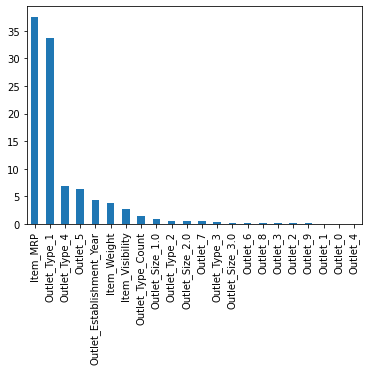

In [0]:
pd.Series(cb_model.best_estimator_.feature_importances_,Z.columns).sort_values(ascending=False).plot(kind='bar')

In [0]:
test = pd.read_csv("bmtest.csv")


In [0]:
test['Item_Fat_Content'].replace(['Low Fat','LF','low fat'],1,inplace=True)
test['Item_Fat_Content'].replace(['Regular','reg'],2,inplace=True)
test['Outlet_Establishment_Year'] = current_year - test['Outlet_Establishment_Year'] 
test['Outlet_Size'].replace({'Small':1,'Medium':2,'High':3},inplace=True)
test['Outlet_Location_Type'].replace({'Tier 1':1,'Tier 2':2,'Tier 3':3},inplace=True)
test['Outlet_Type'].replace({'Grocery Store':1,'Supermarket Type1':2,'Supermarket Type2':3,'Supermarket Type3':4},inplace=True)
test['Item_Visibility'].replace(0,pd.NA,inplace=True)
test['Outlet'] = le.fit_transform(test['Outlet_Identifier'])

In [0]:
a = imputer.fit_transform(test.drop(columns=['Item_Identifier','Outlet_Identifier','Item_Type']))

'''categorical column whose values needed to be rounded off'''
c_cat = pd.DataFrame(np.round(a[:,5]),columns=['Outlet_Size'])

'''non-categorical columns where value do not need to be and'''
c_ncat = pd.DataFrame(a[:,[0,2]],columns=['Item_Weight','Item_Visibility'])

test[['Item_Weight','Item_Visibility']] = c_ncat[['Item_Weight','Item_Visibility']]
test[['Outlet_Size']] = c_cat[['Outlet_Size']]

In [0]:
#test = pd.DataFrame(np.round(imputer.fit_transform(test.drop(columns=['Item_Identifier','Outlet_Identifier','Item_Type']))),
                   #columns = test.drop(columns=['Item_Identifier','Outlet_Identifier','Item_Type']).columns)


In [0]:
for var in ['Outlet_Type']:   
    d = test[var].value_counts().to_dict()
    c_string = var + '_Count'
    test[c_string] = test[var].map(d)

In [0]:
test=pd.get_dummies(test,columns=['Outlet_Type','Outlet','Outlet_Size']) 

## Modelling for testing

In [0]:
Z_test = test.drop(columns=['Item_Identifier','Item_Fat_Content','Outlet_Location_Type',
                            'Item_Type','Outlet_Identifier'])

In [0]:
cb_model.fit(Z,y)
Yhat = cb_model.predict(Z_test)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.7s finished


In [0]:
df3 = pd.read_csv("bmtest.csv")
df1 = pd.DataFrame(Yhat)
df2 = pd.concat([df3[['Item_Identifier','Outlet_Identifier']], df1], axis=1)
df2.rename(columns={0: 'Item_Outlet_Sales'}, inplace=True)
df2.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1696.631238
1,FDW14,OUT017,1343.827184
2,NCN55,OUT010,953.061644
3,FDQ58,OUT017,2504.159881
4,FDY38,OUT027,5425.939370


In [0]:
export_csv = df2.to_csv(r'C:\Users\DELL\ipynb notebooks\Submission_bigm.csv', index = None, header=True)